In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_fscore_support
from scipy.stats import f, ttest_ind, chi2

In [20]:
# data at first glance
data = pd.read_csv('BitcoinHeistData.csv')
data.rename(columns={'count':'counted'},inplace=True)

In [21]:
# create binary labels
data.loc[data['label'] == 'white', 'blabel'] = 0
data.loc[data['label'] != 'white', 'blabel'] = 1
# redefine date variable
data['date'] = (np.asarray(data['year'], dtype='datetime64[Y]')-1970)+(np.asarray(data['day'], dtype='timedelta64[D]')-1)

In [22]:
data.head()

,address,year,day,length,weight,counted,looped,neighbors,income,label,blabel,date
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber,1.0,2017-01-11
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky,1.0,2016-05-11
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber,1.0,2016-09-02
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber,1.0,2016-11-17
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky,1.0,2016-08-25


In [81]:
class SimilaritySearch:

    def __init__(self, X, period, familyList):
        self.data = X
        self.period = period
        self.family = familyList
        self.white = None
        self.heist = None
        self.processed = None
        self.shreshold = 0.001
    

    #function that distinguish white and non-white dataset
    def preprocessing(self):
        self.white = self.data.loc[self.data['blabel'] == 0, ].copy()
        self.heist = self.data.loc[self.data['blabel'] == 1, ].copy()


    # function that defines Mahalanobis distance
    def mahalanobis(self, x, data, cov=None):
        
        """
        Compute the Mahalanobis Distance between each row of x and the data  
        x    : vector or matrix of data with, say, p columns.
        data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
        cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
        """
        
        x_minus_mu = x - np.mean(data)
        
        if not cov:
            cov = np.cov(data.values.T)
        try:
            inv_covmat = np.linalg.inv(cov)
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                inv_covmat = np.linalg.pinv(cov)
            else:
                raise
        
        left_term = np.dot(x_minus_mu, inv_covmat)
        mahal = np.dot(left_term, x_minus_mu.T)
        
        return np.sqrt(mahal.diagonal())


    # function that does similarity check
    def anomaly_detection(self, x, heist, cov = None, period = 15, name = 'Locker'):
        
        """
        Compute the sliding-window Mahalanobis Distance of non-reported white address to the known ransomware address

        x    : the non-reported white address
        data : the known ransomware address
        cov  : covariance matrix (p x p). If None, will be computed from data.
        period: the length of slicing window
        name: the name of ransomware family
        """
        
        col_name1 = 'dist_'+name
        col_name2 = 'pval_'+name

        df = x[['address', 'date', 'label']]
        dates = np.unique(x['date'])
        
        for pdate in dates[period:]:
            start_date = pdate - np.timedelta64(period,'D')
            
            #heist data of training period
            mask = (heist['date'] >= start_date)&(heist['date'] < pdate)
            temp_data = heist.loc[mask,]
            
            if len(temp_data) == 0:
                continue
            
            today = x.loc[x['date'] == pdate,]
            temp_index = today.index
            
            df.loc[temp_index,col_name1] = self.mahalanobis(today.iloc[:,3:9], temp_data.iloc[:,3:9], cov = cov)
            df.loc[temp_index,col_name2] = 1-chi2.cdf(df.loc[temp_index,col_name1], 2)

        return df

    def fit(self):

        ransom_list = []
        self.preprocessing()

        for name in self.family:
            print(name)
            ransom_data = self.heist.loc[self.heist['label'] == name,]
            prediction = self.anomaly_detection(self.white, ransom_data, cov = None, period = self.period, name = name)
            prediction = prediction.dropna()
            ransom_list.append(prediction)

        result = pd.concat(ransom_list)
        return result

In [82]:
X = data
common_period = 15
common_ransom_list = ['princetonCerber',
 'princetonLocky',
 'montrealCryptoLocker',
 'montrealCryptXXX',
 'paduaCryptoWall',
 'montrealNoobCrypt',
 'montrealDMALockerv3',
 'montrealDMALocker']

In [83]:
similarity = SimilaritySearch(X, period=common_period, familyList=common_ransom_list)
result = similarity.fit()

princetonCerber


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

princetonLocky


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

montrealCryptoLocker


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

montrealCryptXXX


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

paduaCryptoWall


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

montrealNoobCrypt


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

montrealDMALockerv3


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/Sharonvy/opt/anaconda3/lib/python3.7/

montrealDMALocker


/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: Set

In [84]:
result

,address,date,label,dist_princetonCerber,pval_princetonCerber,dist_princetonLocky,pval_princetonLocky,dist_montrealCryptoLocker,pval_montrealCryptoLocker,dist_montrealCryptXXX,pval_montrealCryptXXX,dist_paduaCryptoWall,pval_paduaCryptoWall,dist_montrealNoobCrypt,pval_montrealNoobCrypt,dist_montrealDMALockerv3,pval_montrealDMALockerv3,dist_montrealDMALocker,pval_montrealDMALocker
1927697,16Uak2n1Q4XipYSjAauEtrYKjXN71wN9LY,2016-03-12,white,698.790273,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927698,1KcwrCHLudjYcZsrSzBuAaaPiABiDcMyjF,2016-03-12,white,91.218939,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927699,12orRUgZhggvThbtpmqiueWC6gAie5cqyx,2016-03-12,white,0.832078,0.659654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927700,1BZrbKHrB7ZCwNuvz1xqWm2gQmAZFEmPY4,2016-03-12,white,1.888388,0.388993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927701,19VynCkgrZdHhDVey6k927baXitMNy9dNw,2016-03-12,white,1.478826,0.477394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103692,1LMdTEPXXztgc2wvBhRYi6nFp1TpdmeyeF,2016-09-03,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.545760,0.169843
2103693,1B1osypfPhR1JbpzvHMiikNZyNC7dcS529,2016-09-03,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.544956,0.280137
2103694,1Jg2S4SgPWShVC29dMQrJvHouGXZDhCuBy,2016-09-03,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.631500,0.162716
2103695,1P2Njde7LUC4qrrf5w1ibRz5o8diajUtc,2016-09-03,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.101602,0.000193


In [94]:
result.to_csv('distance_result_final.csv')

In [3]:
result = pd.read_csv("distance_result_final.csv").iloc[:, 1:]
result.head()

,address,date,label,dist_princetonCerber,pval_princetonCerber,dist_princetonLocky,pval_princetonLocky,dist_montrealCryptoLocker,pval_montrealCryptoLocker,dist_montrealCryptXXX,pval_montrealCryptXXX,dist_paduaCryptoWall,pval_paduaCryptoWall,dist_montrealNoobCrypt,pval_montrealNoobCrypt,dist_montrealDMALockerv3,pval_montrealDMALockerv3,dist_montrealDMALocker,pval_montrealDMALocker,year
0,16Uak2n1Q4XipYSjAauEtrYKjXN71wN9LY,2016-03-12,white,698.790273,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,1KcwrCHLudjYcZsrSzBuAaaPiABiDcMyjF,2016-03-12,white,91.218939,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
2,12orRUgZhggvThbtpmqiueWC6gAie5cqyx,2016-03-12,white,0.832078,0.659654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
3,1BZrbKHrB7ZCwNuvz1xqWm2gQmAZFEmPY4,2016-03-12,white,1.888388,0.388993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
4,19VynCkgrZdHhDVey6k927baXitMNy9dNw,2016-03-12,white,1.478826,0.477394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016


In [85]:
result['year'] = pd.DatetimeIndex(result['date']).year

In [86]:
years = np.unique(result['year'])
common_ransom_list = ['princetonCerber',
 'princetonLocky',
 'montrealCryptoLocker',
 'montrealCryptXXX',
 'paduaCryptoWall',
 'montrealNoobCrypt',
 'montrealDMALockerv3',
 'montrealDMALocker']

In [91]:
result_table = pd.DataFrame(index = common_ransom_list, columns = years, dtype = np.int32)
for name in common_ransom_list:
    col_name = 'dist_'+name
    for y in years:
        temp1 = result.loc[result['year'] == y, col_name]
        if len(temp1) == 0:
            result_table.loc[name,y] = len(temp1)
        else:
            temp_data = temp1.loc[temp1 <= 0.1]
            result_table.loc[name,y] = len(temp_data)
        

In [92]:
result_table

,2011,2012,2013,2014,2015,2016,2017
princetonCerber,0.0,0.0,0.0,0.0,0.0,177.0,0.0
princetonLocky,0.0,0.0,0.0,0.0,0.0,12.0,379.0
montrealCryptoLocker,1021.0,6444.0,767.0,503.0,19.0,0.0,0.0
montrealCryptXXX,0.0,0.0,0.0,0.0,0.0,69.0,0.0
paduaCryptoWall,0.0,0.0,0.0,457.0,84.0,0.0,0.0
montrealNoobCrypt,0.0,0.0,0.0,5217.0,2222.0,838.0,0.0
montrealDMALockerv3,0.0,0.0,0.0,0.0,0.0,53.0,135.0
montrealDMALocker,0.0,0.0,0.0,0.0,2004.0,1290.0,0.0


In [93]:
np.sum(result_table)

2011    1021.0
2012    6444.0
2013     767.0
2014    6177.0
2015    4329.0
2016    2439.0
2017     514.0
dtype: float64

In [5]:
df2 = result.filter(regex='dist')
df2['min'] = np.min(df2, axis = 1)
df2['date'] = result['date']
df2.head()

/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,dist_princetonCerber,dist_princetonLocky,dist_montrealCryptoLocker,dist_montrealCryptXXX,dist_paduaCryptoWall,dist_montrealNoobCrypt,dist_montrealDMALockerv3,dist_montrealDMALocker,min,date
0,698.790273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698.790273,2016-03-12
1,91.218939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.218939,2016-03-12
2,0.832078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.832078,2016-03-12
3,1.888388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.888388,2016-03-12
4,1.478826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.478826,2016-03-12


In [11]:
temp = df2.loc[df2['min'] <= 0.1]
grouped_data = temp.groupby(['date']).count()

In [13]:
grouped_data['sum'] = np.sum(grouped_data.iloc[:,:-1], axis = 1)

In [17]:
frequency_predict = grouped_data[['sum']]

In [41]:
common_ransom_list = ['princetonCerber',
 'princetonLocky',
 'montrealCryptoLocker',
 'montrealCryptXXX',
 'paduaCryptoWall',
 'montrealNoobCrypt',
 'montrealDMALockerv3',
 'montrealDMALocker']
heist = data.loc[data['blabel'] == 1,]
heist = heist.loc[heist['label'].isin(common_ransom_list),]
grouped_heist = heist.groupby(['date']).count()

In [42]:
frequency_true = grouped_heist[['label']]

In [43]:
frequency = frequency_predict.merge(frequency_true, how='left', left_index = True, right_index = True)

In [44]:
frequency = frequency.fillna(0)
frequency['Date'] = frequency.index

In [87]:
frequency.rename(columns={'sum':'False Positive'},inplace=True)
frequency.rename(columns={'label':'True Positive'},inplace=True)

In [88]:
frequency

,False Positive,True Positive,Date
date,,,
2011-09-12,28,0.0,2011-09-12
2011-09-13,33,0.0,2011-09-13
2011-09-14,37,0.0,2011-09-14
2011-09-15,30,0.0,2011-09-15
2011-09-16,36,0.0,2011-09-16
...,...,...,...
2017-07-05,2,5.0,2017-07-05
2017-08-11,1,7.0,2017-08-11
2017-08-15,1,0.0,2017-08-15


In [116]:
frequency.sort_values(by=['False Positive'], asc = False)

,False Positive,True Positive,Date
date,,,
2017-09-24,1,0.0,2017-09-24
2014-07-11,1,41.0,2014-07-11
2016-05-20,1,113.0,2016-05-20
2014-04-12,1,60.0,2014-04-12
2014-04-07,1,78.0,2014-04-07
...,...,...,...
2012-10-29,112,4.0,2012-10-29
2013-02-19,112,3.0,2013-02-19
2012-12-13,118,2.0,2012-12-13


In [115]:
np.sum(frequency['False Positive'])

21691

In [109]:
import matplotlib.dates as mdates

tidy = frequency.melt(id_vars='Date').rename(columns=str.title)
tidy['Date'] = pd.to_datetime(tidy['Date'], format = '%Y-%m-%d').astype(str)
tidy.head()

,Date,Variable,Value
0,2011-09-12,False Positive,28.0
1,2011-09-13,False Positive,33.0
2,2011-09-14,False Positive,37.0
3,2011-09-15,False Positive,30.0
4,2011-09-16,False Positive,36.0


In [110]:
tidy['Date']

0       2011-09-12
1       2011-09-13
2       2011-09-14
3       2011-09-15
4       2011-09-16
           ...    
1375    2017-07-05
1376    2017-08-11
1377    2017-08-15
1378    2017-08-23
1379    2017-09-24
Name: Date, Length: 1380, dtype: object

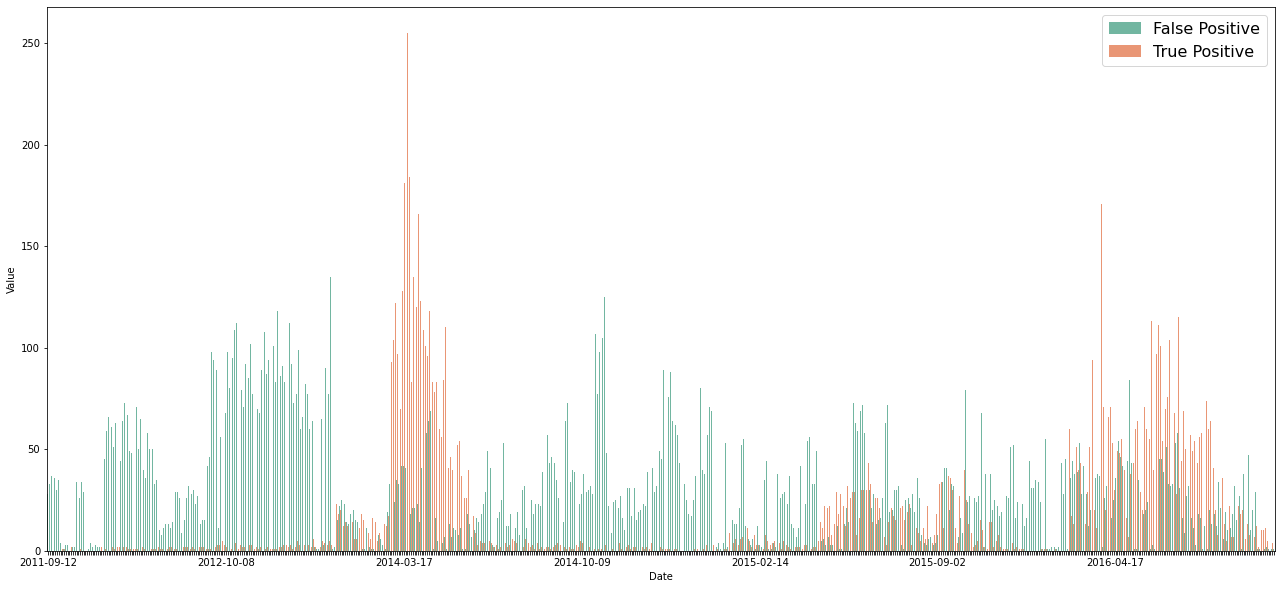

In [113]:
fig, ax1 = plt.subplots(figsize=(22, 10))
plot_ = sns.barplot(x='Date', y='Value', hue='Variable', data=tidy, ax=ax1, palette = 'Set2')
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 100 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.legend(fontsize=16)
plt.show()